### Housekeeping

In [0]:
import pandas as pd
import random
import numpy as np
import librosa
import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [0]:
#DATA_PATH = "D:\\Datasets\\mozilla\\"
#CLIPS_PATH = "D:\\Datasets\\mozilla\\clips\\"
#TRAIN_DATA = "validated.tsv"

DATA_PATH = "/dev-clips/"
CLIPS_PATH = "/content/dev-clips/"
TRAIN_DATA = "dev.tsv"

In [3]:
!curl https://cv-audio.s3.us-south.cloud-object-storage.appdomain.cloud/dev-clips.tgz -o dev-clips.tgz
!tar -zxvf dev-clips.tgz dev-clips

Streaming output truncated to the last 5000 lines.
dev-clips/common_voice_en_18642208.mp3
dev-clips/common_voice_en_19690945.mp3
dev-clips/common_voice_en_18745789.mp3
dev-clips/common_voice_en_682310.mp3
dev-clips/common_voice_en_19653239.mp3
dev-clips/common_voice_en_563207.mp3
dev-clips/common_voice_en_19495744.mp3
dev-clips/common_voice_en_19999062.mp3
dev-clips/common_voice_en_19463502.mp3
dev-clips/common_voice_en_19514159.mp3
dev-clips/common_voice_en_18563832.mp3
dev-clips/common_voice_en_19961600.mp3
dev-clips/common_voice_en_19945676.mp3
dev-clips/common_voice_en_20161468.mp3
dev-clips/common_voice_en_19745477.mp3
dev-clips/common_voice_en_19081342.mp3
dev-clips/common_voice_en_18519223.mp3
dev-clips/common_voice_en_654042.mp3
dev-clips/common_voice_en_20024895.mp3
dev-clips/common_voice_en_19511866.mp3
dev-clips/common_voice_en_18631596.mp3
dev-clips/common_voice_en_19596842.mp3
dev-clips/common_voice_en_19944029.mp3
dev-clips/common_voice_en_19956741.mp3
dev-clips/common_vo

In [4]:
!curl https://cv-audio.s3.us-south.cloud-object-storage.appdomain.cloud/dev.tsv -o dev.tsv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3472k  100 3472k    0     0  2793k      0  0:00:01  0:00:01 --:--:-- 2793k


### EDA

In [0]:
df = pd.read_csv(TRAIN_DATA, sep='\t')

In [6]:
df.head()

,client_id,path,sentence,up_votes,down_votes,age,gender,accent
0,d277a1f3904ae00b09b73122b87674e7c2c78e08120721...,common_voice_en_18540003.mp3,"When water is scarce, avoid wasting it.",2,0,NaN,NaN,NaN
1,d277a1f3904ae00b09b73122b87674e7c2c78e08120721...,common_voice_en_18540005.mp3,You will drive with her to her door.,2,1,NaN,NaN,NaN
2,d277a1f3904ae00b09b73122b87674e7c2c78e08120721...,common_voice_en_18540006.mp3,"Celia shrank back, shivering.",2,1,NaN,NaN,NaN
3,d28566a5d710dbd7e6c2ab4686ad5bd22ec86588a3abd1...,common_voice_en_65557.mp3,Have you got a ring?,2,0,thirties,male,indian
4,d28566a5d710dbd7e6c2ab4686ad5bd22ec86588a3abd1...,common_voice_en_65559.mp3,I didn't even ask him.,2,0,thirties,male,indian


In [7]:
df.describe()

,up_votes,down_votes
count,15531.000000,15531.000000
mean,2.064452,0.223682
std,0.303498,0.429808
min,2.000000,0.000000
25%,2.000000,0.000000
50%,2.000000,0.000000
75%,2.000000,0.000000
max,19.000000,3.000000


In [8]:
len(df)

15531

In [9]:
df.isna().sum()

client_id         0
path              0
sentence          0
up_votes          0
down_votes        0
age           12016
gender        12015
accent        13431
dtype: int64

In [10]:
# mozilla site says 354 voices, assuming 319 validated
df.nunique()

client_id      4373
path          15531
sentence      15531
up_votes          8
down_votes        4
age               9
gender            3
accent           16
dtype: int64

In [11]:
len(df[df.down_votes == 0]) / len(df)

0.7815337067799885

In [0]:
import librosa.display
def plot_spectrogram(clip,title='Constant-Q power spectrogram (Hz)'):
    wave, sr = librosa.load(clip)
    plt.figure(figsize=(5,3))
    CQT = librosa.amplitude_to_db(librosa.cqt(wave, sr=sr), ref=np.max)
    librosa.display.specshow(CQT, y_axis='cqt_hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)

/usr/local/lib/python3.6/dist-packages/librosa/core/spectrum.py:983: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


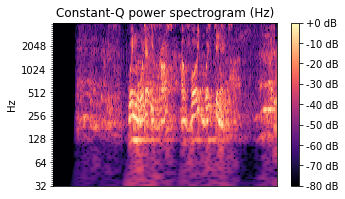

In [13]:
clip = '/content/' + DATA_PATH + df['path'][0]
plot_spectrogram(clip)

In [14]:
l = librosa.load(clip)
l

(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 22050)

### Pairing Data

In [15]:
data = df[df.down_votes == 0]
data.nunique()

client_id      4189
path          12138
sentence      12138
up_votes          6
down_votes        1
age               9
gender            3
accent           16
dtype: int64

In [0]:
voices_sorted = data.sort_values(by=['client_id'], ascending=True)[['client_id', 'path']].values.tolist()
voices_reversed = data.sort_values(by=['client_id'], ascending=False)[['client_id', 'path']].values.tolist()

In [0]:
positive_pairs = []
negative_pairs = []

# reads a record from the ordered list by client id
current_item = voices_sorted.pop(0)

while len(voices_sorted) != 0:
    
    #gets the following record
    next_item = voices_sorted.pop(0) 
    
    if(current_item[0] == next_item[0]):
        
        # if is the same voice, adds to pairing dataset
        positive_pairs.append([
            current_item[0], 
            current_item[1], 
            next_item[1], 
            1])
        
        # to mismatch voices, pop from the reversed sorted list
        mismatched = voices_reversed.pop(0)
        
        if(mismatched[0] == current_item[0]):
            continue
        
        negative_pairs.append([
            current_item[0], 
            current_item[1], 
            mismatched[1], 
            0])
        
    else:
        # if is other voice, saves for the next iteration
        current_item = next_item    

In [18]:
pd.DataFrame(positive_pairs, columns=['client_id', 'path_a', 'path_b', 'label']).head()

,client_id,path_a,path_b,label
0,001324df11d9102ff7faae0c7b13ce45e5098f72a04306...,common_voice_en_19540526.mp3,common_voice_en_19540527.mp3,1
1,002378b4a0c9707177387e9407c270a0d93aacd12886dd...,common_voice_en_19275809.mp3,common_voice_en_19275810.mp3,1
2,002378b4a0c9707177387e9407c270a0d93aacd12886dd...,common_voice_en_19275809.mp3,common_voice_en_19275812.mp3,1
3,002378b4a0c9707177387e9407c270a0d93aacd12886dd...,common_voice_en_19275809.mp3,common_voice_en_19275813.mp3,1
4,0025335d676c57a7103e733abf211b9499406be7687ccd...,common_voice_en_19073077.mp3,common_voice_en_19073079.mp3,1


In [19]:
pd.DataFrame(negative_pairs, columns=['client_id', 'path_a', 'path_b', 'label']).head()

,client_id,path_a,path_b,label
0,001324df11d9102ff7faae0c7b13ce45e5098f72a04306...,common_voice_en_19540526.mp3,common_voice_en_18787669.mp3,0
1,002378b4a0c9707177387e9407c270a0d93aacd12886dd...,common_voice_en_19275809.mp3,common_voice_en_18787670.mp3,0
2,002378b4a0c9707177387e9407c270a0d93aacd12886dd...,common_voice_en_19275809.mp3,common_voice_en_18787667.mp3,0
3,002378b4a0c9707177387e9407c270a0d93aacd12886dd...,common_voice_en_19275809.mp3,common_voice_en_18275892.mp3,0
4,0025335d676c57a7103e733abf211b9499406be7687ccd...,common_voice_en_19073077.mp3,common_voice_en_18275851.mp3,0


In [20]:
print(len(positive_pairs), len(negative_pairs))

7949 7948


In [21]:
all_pairs = positive_pairs + negative_pairs
random.shuffle(all_pairs)
all_pairs[0]

['3f7ab79400ed67202bc5083a370f4411346a428cb054e95472b943ffc867ab16060b6650614cf4961debbf4b64d4f3fa96547e3c4435bca59e0ffeca688d1804',
 'common_voice_en_19717757.mp3',
 'common_voice_en_19686493.mp3',
 0]

### Loading MP3 files



In [0]:
def get_clip(file_name, max_pad_len=400):
    wave, sr = librosa.load(file_name, mono=True)#, sr=None)
    wave = wave[::3]
    mfcc = librosa.feature.mfcc(wave, sr=sr) #16000)
    #print(mfcc.shape)
    pad_width = max_pad_len - mfcc.shape[1]
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    return mfcc

In [23]:
test = True

if(test):
    test_pairs = all_pairs
    test_filenames = set(pd.DataFrame(
        test_pairs, 
        columns=['client_id', 'path_a', 'path_b', 'label']
    )[['path_a', 'path_b']].values.ravel().tolist())
    test_filenames = list(test_filenames)

    clips = {}
    for i in tqdm(range(len(test_filenames))):
        f = CLIPS_PATH + test_filenames[i]
        clips.update({f: get_clip(f)})
    
else:
    clips = {}
    filenames = glob.glob(CLIPS_PATH + '*.mp3')
    for i in tqdm(range(len(filenames))):
        clips.update({filenames[i]: get_clip(filenames[i])})

In [0]:
import pickle
with open('clips.pickle', 'wb') as f:
    pickle.dump(clips, f)

In [25]:
clips

{'/content/dev-clips/common_voice_en_18900842.mp3': array([[-6.76662497e+02, -6.36116852e+02, -4.07230023e+02, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  4.64563114e+01,  6.02918500e+01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  2.75040919e+01,  2.66231359e+01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00, -1.91990540e+00, -3.01597351e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00, -2.58006981e+00, -4.72555949e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00, -2.36431358e+00, -1.99604117e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]),
 '/content/dev-clips/common_voice_en_19576715.mp3': array([[-669.80617894, -669.80617894, -545.62266457, ...,    0.        ,
            0.        ,    0.        ],
        [   0

In [0]:
def get_dataset():
    pairs = []
    labels = []  
    
    if(test):
        p = test_pairs
    else:
        p = all_pairs

    for pair in p:     
        pairs.append([
            clips.get(CLIPS_PATH + pair[1]), 
            clips.get(CLIPS_PATH + pair[2])])
        labels.append(pair[3])
    
    dataset_size = len(p)
    train_size = int(dataset_size*0.8)
    
    pairs = np.array(pairs)
    labels = np.array(labels)
    print(pairs.shape, labels.shape)
    
    return pairs[0:train_size], pairs[train_size:dataset_size], labels[0:train_size], labels[train_size:dataset_size]

In [0]:
train_pairs, val_pairs, train_labels, val_labels = get_dataset()

In [0]:
print(train_pairs.shape, val_pairs.shape, train_labels.shape, val_labels.shape)

In [0]:
INPUT_SHAPE = train_pairs.shape[2:]
INPUT_SHAPE

### Create Model

In [0]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input, optimizers, metrics
from tensorflow.keras import backend as K

def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

def create_base_network():
    '''Base network to be shared (eq. to feature extraction).
    '''
    model = models.Sequential()
    model.add(layers.Input(shape=INPUT_SHAPE))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.1))
    
    return model
    
def get_model():
    base_network = create_base_network()
    input_a = Input(shape=INPUT_SHAPE)
    input_b = Input(shape=INPUT_SHAPE)
    
    # because we re-use the same instance `base_network`, the weights of the network will be shared across the two branches
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)
    
    distance = layers.Lambda(
        euclidean_distance, 
        output_shape = eucl_dist_output_shape)([processed_a, processed_b])
    
    model = models.Model([input_a, input_b], distance)
    return base_network, model

base_network, model = get_model()

model.summary()

In [0]:
EPOCHS = 40
BATCH = 32

model.compile(
    loss = contrastive_loss, 
    optimizer = optimizers.RMSprop(), 
    metrics=[accuracy])

In [0]:
history = model.fit(
    [train_pairs[:, 0], train_pairs[:, 1]], 
    train_labels, 
    batch_size = BATCH, 
    epochs = EPOCHS,
    validation_data = ([val_pairs[:, 0], val_pairs[:, 1]], val_labels))

Train on 800 samples, validate on 200 samples
Epoch 1/40
800/800 [==============================] - 1s 1ms/sample - loss: 1018.9963 - accuracy: 0.5263 - val_loss: 6.0786 - val_accuracy: 0.5089
Epoch 2/40
800/800 [==============================] - 0s 561us/sample - loss: 8.4376 - accuracy: 0.5288 - val_loss: 1.7303 - val_accuracy: 0.4955
Epoch 3/40
800/800 [==============================] - 0s 583us/sample - loss: 1.1712 - accuracy: 0.5587 - val_loss: 1.1586 - val_accuracy: 0.4777
Epoch 4/40
800/800 [==============================] - 0s 547us/sample - loss: 1.0048 - accuracy: 0.5587 - val_loss: 0.8639 - val_accuracy: 0.4955
Epoch 5/40
800/800 [==============================] - 0s 608us/sample - loss: 1.0942 - accuracy: 0.5462 - val_loss: 0.6693 - val_accuracy: 0.5179
Epoch 6/40
800/800 [==============================] - 0s 577us/sample - loss: 0.5080 - accuracy: 0.5250 - val_loss: 4.7463 - val_accuracy: 0.5089
Epoch 7/40
800/800 [==============================] - 0s 600us/sample - loss:

In [0]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


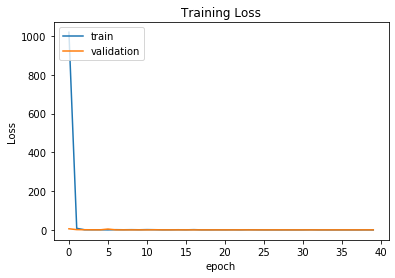

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

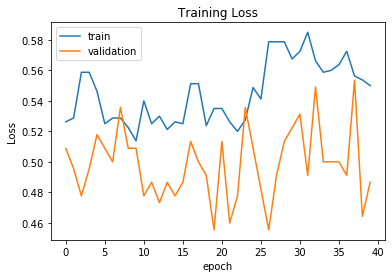

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()